In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
dados = pd.read_csv("eleicoes_2006_a_2010.csv")

In [3]:
numeric_feats = dados.dtypes[dados.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
dados[numeric_feats] = dados.groupby(['partido', 'uf', 'ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido', 'uf'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

skewed_feats = dados[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
dados[skewed_feats] = np.log1p(dados[skewed_feats])

dados = dados.fillna(dados.median())

In [4]:
dados = pd.get_dummies(dados, columns = ["uf","partido","cargo","sexo","grau","estado_civil","ocupacao"])

dados = dados.drop(columns = ['nome', 'sequencial_candidato'])

In [5]:
treino =  dados[dados.ano == 2006]
y_treino = treino.votos
treino = treino.drop(columns = ['votos'])

teste = dados[dados.ano == 2010]
y_teste = teste.votos
teste = teste.drop(columns = ['votos'])

In [6]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [7]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, treino, y_treino, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)


In [8]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 7,8,9,10,11,12,13,15, 20,30,40,45, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

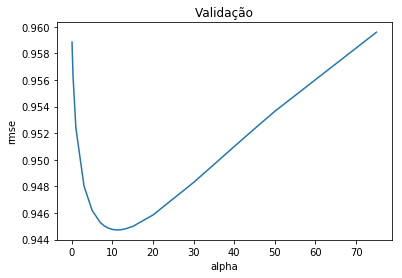

In [9]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [10]:
cv_ridge.min()

0.9447270118637288

In [11]:
alphas = [0.0001,0.005,0.0005,0.05, 0.1, 0.3, 1]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=10000)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

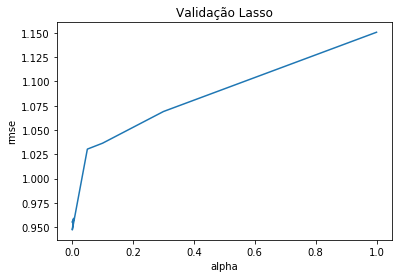

In [12]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validação Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [13]:
cv_lasso.min()

0.9470633157781423

In [14]:
model_lasso = Lasso(alpha = cv_lasso.idxmin(), max_iter=10000)
model_lasso.fit(treino, y_treino)
coef = pd.Series(model_lasso.coef_, index = treino.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 130 variables and eliminated the other 131 variables


In [15]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

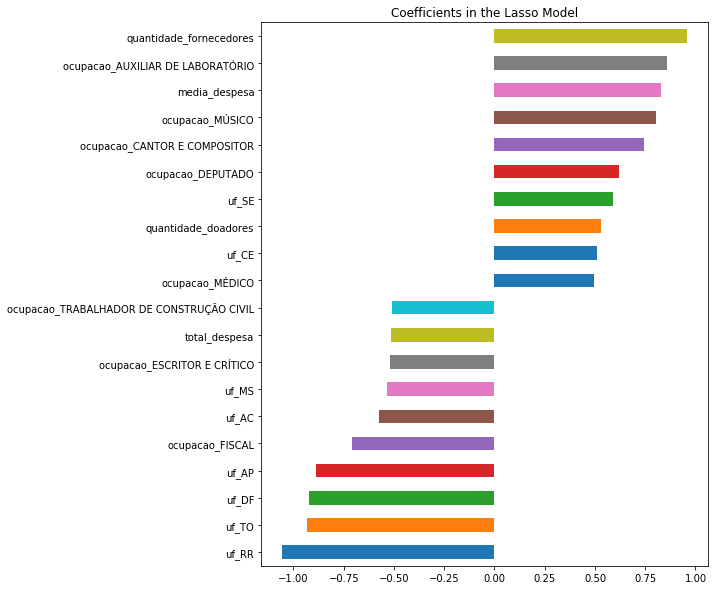

In [16]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

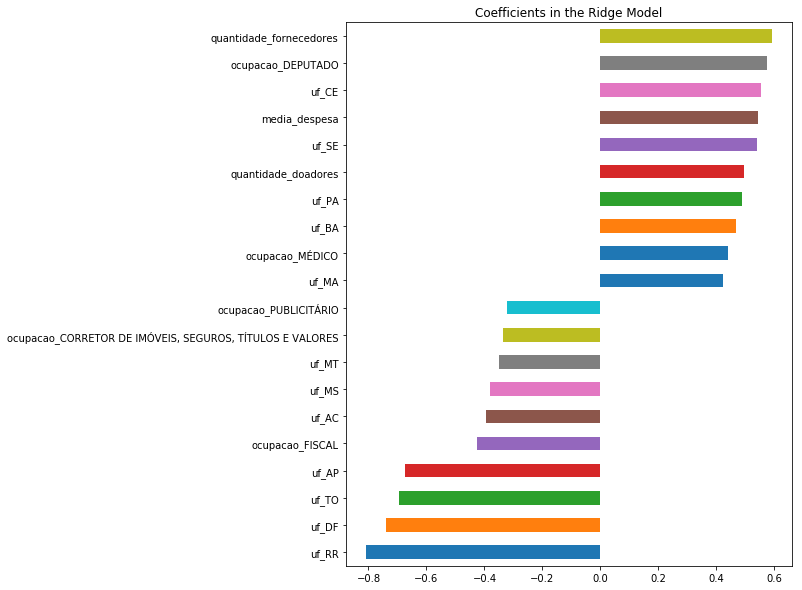

In [17]:
model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(treino, y_treino)
coef_ridge = pd.Series(model_ridge.coef_, index = treino.columns)
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [18]:
r_squared_lasso = model_lasso.score(teste, y_teste)
print(r_squared_lasso)
r_squared_ridge = model_ridge.score(teste, y_teste)
print(r_squared_ridge)

0.7091441188383224
0.7097964793544046
